In [8]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [2]:
# importing all following data and putting in a graph
pkl_file = open('Unfollower/15weeks_friend_dict.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

week = 0
for key, values in mydict2.items():
    if len(values[week]) == 0:
        mydict2[key] = []
        continue
    new = values[week][1]
    mydict2[key] = new

# mydict2 has format:
# user_id: [following_user_id1, following_user_id2...]

In [37]:
# forrest fire sampling implementation and use 
def forest_fire_sampling(graph_dict, initial_burn_probability, secondary_burn_probability, max_samples=None):
    # Choose a random start node
    start_node = random.choice(list(graph_dict.keys()))
    
    # Force starting node to have at least 100 friends 
    if len(graph_dict[start_node]) < 100:
        start_node = random.choice(list(graph_dict.keys()))
    sampled_nodes = set([start_node])
    burning_nodes = set([start_node])
    
    while burning_nodes:
        new_burning_nodes = set()
        for node in burning_nodes:
            # For each neighbor, decide if it catches fire based on the burn probability
            for neighbor in graph_dict[node]:
                if neighbor not in sampled_nodes:
                    if random.random() < (initial_burn_probability if node == start_node else secondary_burn_probability):
                        new_burning_nodes.add(neighbor)
                        sampled_nodes.add(neighbor)
                        if max_samples and len(sampled_nodes) >= max_samples:
                            return sampled_nodes
        burning_nodes = new_burning_nodes

    return sampled_nodes

# sampling has undeterministic results where sample may have few nodes or many nodes depending on whether random starting node has many or few neighbors. We may want to force the starting node to have more than 10 friends. 
sample = forest_fire_sampling(mydict2, 0.2, 0.1, max_samples=1000)
shortened_dict = defaultdict(list)
print(len(mydict2))
for k in mydict2:
    if k in sample: 
        for v in mydict2[k]:
            if v in sample: 
                shortened_dict[k].append(v)
print(len(shortened_dict))

{'700793835207536640', '4878992127', '859788578', '382134761', '492169001', '705401185851805696', '22026168', '3093591389', '17094747', '14135186', '15045590', '1264438328', '823323504263229440', '57571700', '311404595', '620152498', '3094891', '27301650', '103881149', '536323744', '575376342', '14754639', '617243', '147834054', '23720825', '71905822', '12551552', '2264702275', '14124984', '38192556', '134174402', '16932489', '22592773', '190238907', '274188487', '35398550', '848385648', '2801581', '180835403', '17270684', '5469572', '531737225', '109533154', '20766200', '74386296', '15337065', '844989299187744768', '28108594', '1444716745', '146536061', '2328933301', '14118112', '119341695', '1884704035', '40737859', '90155533', '56686035', '70478255', '2178855164', '3948752537', '14742654', '745339323420053504', '11493602', '8249522', '1962699368', '962427258953764865', '21689241', '18714213', '814881', '101013718', '59361871', '2858893210', '1686739147', '3503321908', '2234914806', 

In [3]:
# Alternative Sampling Method 
shortened_dict = {}
follower_ub = 15
follower_lb = 4
sample_size = 100
print(len(mydict2))
i = 0
for k, v in mydict2.items():
    if len(v) > follower_ub or len(v) <= follower_lb: continue
    if i >= sample_size: break
    i += 1
    shortened_dict[k] = v

# shortened dict only takes first 20 people with between 5 and 15 friends
print(len(shortened_dict))

118640
100


882


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


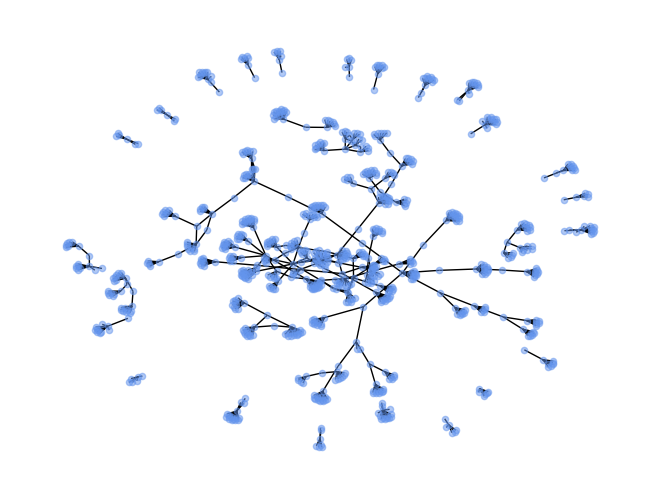

In [4]:
# Creating sample graph and drawing it 
followers_graph = nx.Graph()
for k, v in shortened_dict.items():
    for neighbor in v:
        followers_graph.add_edge(k, neighbor)

print(followers_graph.number_of_nodes())

# Draw the graph
# node
nx.draw(followers_graph, with_labels=False, node_size=20, node_color=(0.392, 0.584, 0.929, 0.5))

# Display the graph
plt.show()

In [13]:
# Creating graph from entire dataset 
followers_graph = nx.Graph()
for k, v in mydict2.items():
    for neighbor in v:
        followers_graph.add_edge(k, neighbor)

print(followers_graph.number_of_nodes())

118633
